In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import time

import glob
from PIL import Image
import pickle
import os
from skimage import io


import waveorder as wo


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


In [6]:
n_media       = 1.512                   # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 63                  # magnification of the microscope                      
NA_obj        = 1.47                # detection NA of the objective
NA_illu       = 0.9                 # illumination NA of the condenser
N_defocus     = 19                   # number of defocus images
N_channel     = 5                   # number of Polscope channels
z_step        = 0.5               # z_step of the stack
z_defocus     = -(np.r_[:N_defocus]-3)*z_step
chi           = 0.03*2*np.pi        # swing of the LC
ps            = 6.45/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = True                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'local_fit'         # background correction method for Polscope recon (does not affect phase)
data_path     = '/gpfs/CompMicro/Spinningdisk/RawData/virtualstaining/2019_04_11_HEK_U2OS_CollagenCoating/2019_04_11_U2OS_plin2_Col_Dividing2_4/Pos0/'        # data path
bg_path       = '/gpfs/CompMicro/Spinningdisk/RawData/virtualstaining/2019_04_11_HEK_U2OS_CollagenCoating/BG_2019_0411_1128_1/Pos0/'           # background data path
output_path   = '/gpfs/CompMicro/Projects/nucleolus/labelfree_segmentation/test/'      # output image path
use_gpu       = True

In [7]:
# solver option

deconv = 'TV'         # deconvolution method

if deconv == 'Tikhonov':
    reg_u = 1e-1      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-3      # phase regularizer
    
elif deconv == 'TV':
    lambda_u = 1e-2   # absorption regularizer
    lambda_p = 1e-2   # phase regularizer
    rho = 1           # rho coefficient of ADMM algorithm (the larger the less noisy and contrast)
    itr = 10          # number of ADMM iteration (10 is usually good)
    verbose = False   # report of the iteration number or not

In [8]:
# Plot setting

max_phase = 3.5                     # maximum phase value to display
min_phase = -0.5                     # minimum phase value to display

max_ret   = 2.5e-3/lambda_illu*2*np.pi # maximum retardance value
all_z     = False                    # plot all z birefringence or not
z_layer   = 3                        # focal layer to plot if only plot single layer

In [9]:
filedir = data_path + '*00000_State*.tif'
filedir_bg = bg_path + '*State*.tif'
files = sorted(glob.glob(filedir), key=wo.numericalSort)
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

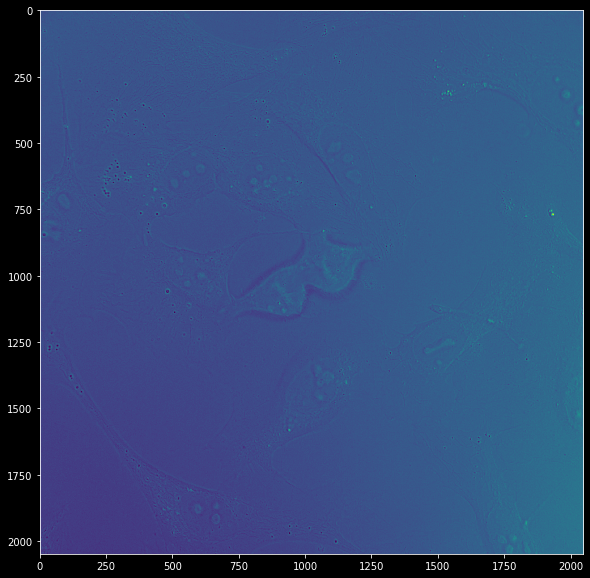

In [10]:
# select a FOV for processing

# Ns = 600
# Ms = 600
# n_start = [550, 1400] 

Ns = 2048
Ms = 2048
n_start = [0, 0] 


plt.figure(figsize=(10,10))
plt.imshow(plt.imread(files[0]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms])


In [11]:
filedir = data_path + '*_State*.tif'
files = sorted(glob.glob(filedir), key=wo.numericalSort)

In [12]:

setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi,\
                                n_media=n_media, cali=cali, bg_option=bg_option)

In [14]:
output_path

'/gpfs/CompMicro/Projects/nucleolus/labelfree_segmentation/test/'

In [15]:
os.system('mkdir '+output_path)
os.system('mkdir '+output_path+'phase')
os.system('mkdir '+output_path+'birefringence')
os.system('mkdir '+output_path+'birefringence2')

256

In [16]:
output_path + 'phase'

'/gpfs/CompMicro/Projects/nucleolus/labelfree_segmentation/test/phase'

In [17]:
os.system('mkdir '+output_path)
os.system('mkdir '+output_path+'phase')
os.system('mkdir '+output_path+'birefringence')
os.system('mkdir '+output_path+'birefringence2')

init_time = time.time()

Nimg = N_defocus*N_channel
N_time = len(files)//Nimg

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)

I_bg = np.zeros_like(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)


for m in range(N_time):
    
    # Load Polscope images
    I_meas_pre =[]

    for i in range(0, Nimg):
        Itemp = io.imread(files[m*Nimg+i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
        I_meas_pre.append(Itemp)
    I_meas_pre = np.array(I_meas_pre)
    I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))
    
    # intensity mapping to match the theory
    I_meas = np.zeros_like(I_meas_pre)
    for i in range(N_defocus):
        I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])
        

    # Stokes vector recon with bg correction
    S_image_recon = setup.Stokes_recon(I_meas)
    S_bg_recon = setup.Stokes_recon(I_bg)
    

    S_image_tm = setup.Stokes_transform(S_image_recon,use_gpu=use_gpu)
    S_bg_tm = setup.Stokes_transform(S_bg_recon,use_gpu=use_gpu)

    
    S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm, use_gpu=use_gpu)  
    
    
    Recon_para = setup.Polarization_recon(S_image_tm,use_gpu=use_gpu)
    


    # Take out S0 for phase reconstruction
    S0_stack = S_image_tm[0].copy()
    
    
    # Phase reconstruction
    
    if deconv == 'Tikhonov':
        mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='Tikhonov', reg_u = reg_u, reg_p = reg_p, use_gpu=use_gpu)
    
    elif deconv == 'TV':
        mu_sample, phi_sample = setup.Phase_recon(S0_stack, method='TV', lambda_u = lambda_u, lambda_p = lambda_p, \
                                                  itr = itr, rho=rho, verbose = verbose, use_gpu=use_gpu)
    
        
    # figure plotting as tiff files
    
    file_name_phase = output_path+'phase/'+files[m*Nimg].split('/')[-1].split('_State')[0]+'_phase.tiff'
    plt.imsave(file_name_phase, phi_sample, format="tiff", cmap=plt.cm.gray, vmin=min_phase, vmax=max_phase)
    
    if all_z == True:
        for i in range(N_defocus):

            bi_hsv = np.transpose(np.array([Recon_para[1,:,:,i]/np.pi, \
                                               np.ones((Ns,Ms)), \
                                               np.clip(Recon_para[0,:,:,i]/max_ret,0,1)]), (1,2,0))
            bi_rgb = hsv_to_rgb(bi_hsv.copy())


            file_name_bire = output_path+'birefringence/'+files[m*Nimg+i].split('state0_')[0].split('/')[1]\
                            +files[m*Nimg+i].split('state0_')[1].split('.')[0]+'_birefringence.tiff'
            plt.imsave(file_name_bire, bi_rgb, format="tiff")
    else:
            bi_hsv_1 = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                               np.ones((Ns,Ms)), \
                                               np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1)]), (1,2,0))
            norm_phase = np.clip(phi_sample, min_phase, max_phase)-min_phase
            norm_phase /= np.max(norm_phase)
            bi_hsv_2 = np.transpose(np.array([Recon_para[1,:,:,z_layer]/np.pi, \
                                               np.clip(Recon_para[0,:,:,z_layer]/max_ret,0,1), \
                                               norm_phase]), (1,2,0))
            bi_rgb_temp = hsv_to_rgb(bi_hsv_1.copy())
            bi_rgb_1 = bi_rgb_temp.copy()


            bi_rgb_temp = hsv_to_rgb(bi_hsv_2.copy())
            bi_rgb_2 = bi_rgb_temp.copy()


            file_name_bire = output_path+'birefringence/'+files[m*Nimg+z_layer].split('/')[-1].split('_State')[0]\
                            +'_'+files[m*Nimg+z_layer].split('/')[-1].split('_State')[1].split('.')[0].split('Acquired ')[1]+'_birefringence.tiff'
            plt.imsave(file_name_bire, bi_rgb_1, format="tiff")
            
            file_name_bire = output_path+'birefringence2/'+files[m*Nimg+z_layer].split('/')[-1].split('_State')[0]\
                            +'_'+files[m*Nimg+z_layer].split('/')[-1].split('_State')[1].split('.')[0].split('Acquired ')[1]+'_birefringence.tiff'
            plt.imsave(file_name_bire, bi_rgb_2, format="tiff")


    
    print('Number of image stacks processed (%d / %d)'%(m+1,N_time))
    
    
    

PermissionError: [Errno 13] Permission denied: '/gpfs/CompMicro/Projects/nucleolus/labelfree_segmentation/test/phase/img_000000000_phase.tiff'